# Computer Vision

## Manipulating Images


### Load an Image


In [ ]:
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import skimage.color as sc

!curl https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme2.jpg -o img.jpg

i = np.array(Image.open('img.jpg'))
imshow(i)

### Examine Numerical Properties of the Image


In [ ]:
type(i)

In [ ]:
i.dtype

In [ ]:
i.shape

In [ ]:
i_mono = sc.rgb2gray(i)
imshow(i_mono, cmap='gray')
i_mono.shape

### View Pixel Value Distributions
Plot a histogram

In [ ]:
def im_hist(img):
    import matplotlib.pyplot as plt    
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()    
    ax.hist(img.flatten(), bins = 256)
    plt.show()

im_hist(i_mono)

Plot a cumulative histogram

In [ ]:
def im_cdf(img):
    import matplotlib.pyplot as plt    
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()    
    ax.hist(img.flatten(), bins = 256, cumulative=True)
    plt.show()
    
im_cdf(i_mono)

### Equalize the Image
Use skimage library to equalize the image.  

In [ ]:
from skimage import exposure

i_eq = exposure.equalize_hist(i_mono)
imshow(i_eq, cmap='gray')

View the histogram and CDF plots:

In [ ]:
im_hist(i_eq)
im_cdf(i_eq)

## Denoising with Filters

### Add Noise

In [ ]:
import skimage
i_n = skimage.util.random_noise(i_eq)
imshow(i_n, cmap="gray")

### Use a Gaussian Filter

In [ ]:
def gauss_filter(im, sigma = 10):
    from scipy.ndimage.filters import gaussian_filter as gf
    import numpy as np
    return gf(im, sigma = sigma)   
i_g = gauss_filter(i_n)
imshow(i_g, cmap="gray")

### Use a Median Filter


In [ ]:
def med_filter(im, size = 10):
    from scipy.ndimage.filters import median_filter as mf
    import numpy as np
    return mf(im, size = size)     
i_m = med_filter(i_n)
imshow(i_m, cmap="gray")

### Extract Features

#### Sobel Edge Detection



In [ ]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

i_edge = edge_sobel(i_m)
imshow(i_edge, cmap="gray")

#### Harris Corner Detection


In [ ]:
def corner_harr(im, min_distance = 10):
    from skimage.feature import corner_harris, corner_peaks
    mag = corner_harris(im)
    return corner_peaks(mag, min_distance = min_distance)

harris = corner_harr(i_eq, 10)


def plot_harris(im, harris, markersize = 20, color = 'red'):
    import matplotlib.pyplot as plt
    import numpy as np
    fig = plt.figure(figsize=(6, 6))
    fig.clf()
    ax = fig.gca()    
    ax.imshow(np.array(im).astype(float), cmap="gray")
    ax.plot(harris[:, 1], harris[:, 0], 'r+', color = color, markersize=markersize)
    return 'Done'  

plot_harris(i_eq, harris)

The corner detection algorithm has identified the eyes in the image.

## Image Classification

### Custom Vision API
https://www.customvision.ai/projects

In [2]:
# Install the Custom Vision SDK
! pip install azure-cognitiveservices-vision-customvision

     |████████████████████████████████| 112kB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 61kB 698kB/s  eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Found existing installation: requests 2.14.2
    Uninstalling requests-2.14.2:
      Successfully uninstalled requests-2.14.2
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
PREDICTION_KEY = 'a7ee1d772cfe4942b5f258fca682a166'
ENDPOINT='https://computervisionbauer13.cognitiveservices.azure.com/'
PROJECT_ID = 'computervisionbauer13'

In [4]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient

import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
%matplotlib inline

# Use two test images
test_img1_url = 'http://www.pachd.com/free-images/food-images/apple-01.jpg'
test_img2_url = 'http://www.pachd.com/free-images/food-images/carrot-02.jpg'

# Create an instance of the prediction service
predictor = CustomVisionPredictionClient(PREDICTION_KEY, endpoint=ENDPOINT)


# Get a prediction for image 1
result1 = predictor.predict_image_url(PROJECT_ID, url=test_img1_url)
# The results include a prediction for each tag, in descending order of probability - so we'll get the first one
prediction1 = result1.predictions[0].tag_name + ": {0:.2f}%".format(result1.predictions[0].probability * 100)

# Get a prediction for image 2
result2 = predictor.predict_image_url(PROJECT_ID, url=test_img2_url)
prediction2 = result2.predictions[0].tag_name + ": {0:.2f}%".format(result2.predictions[0].probability * 100)
    
# Download the images so we can show them
response = requests.get(test_img1_url)
img1 = Image.open(BytesIO(response.content))

response = requests.get(test_img2_url)
img2 = Image.open(BytesIO(response.content))

# Create a figure
fig = plt.figure(figsize=(16, 8))

# Subplot for first image and its predicted class
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(img1)
a.set_title(prediction1)

# Subplot for second image and its predicted class
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(img2)
a.set_title(prediction2)

plt.show()

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


AttributeError: 'CustomVisionPredictionClient' object has no attribute 'predict_image_url'

## Use the Computer Vision API
https://portal.azure.com.



In [8]:
visionURI = 'computervisionbauer13.cognitiveservices.azure.com'
visionKey = 'a7ee1d772cfe4942b5f258fca682a166'

### Get An Image from a URL


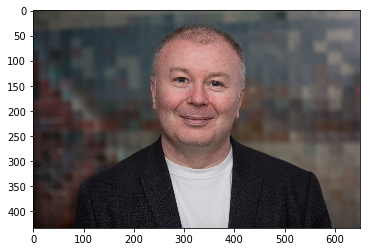

In [9]:
%matplotlib inline
from matplotlib.pyplot import imshow
from PIL import Image
import requests
from io import BytesIO

img_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme2.jpg'

# Get the image and show it
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
imshow(img)


### Use the Computer Vision API to Get Image Features


In [10]:
def get_image_features(img_url):
    import http.client, urllib.request, urllib.parse, urllib.error, base64, json

    headers = {
        # Request headers.
        'Content-Type': 'application/json',
        'Ocp-Apim-Subscription-Key': visionKey,
    }

    params = urllib.parse.urlencode({
        # Request parameters. All of them are optional.
        'visualFeatures': 'Categories,Description,Color',
        'language': 'en',
    })

    body = "{'url':'" + img_url + "'}"

    try:
        # Execute the REST API call and get the response.
        conn = http.client.HTTPSConnection(visionURI)
        conn.request("POST", "/vision/v1.0/analyze?%s" % params, body, headers)
        response = conn.getresponse()
        data = response.read().decode("UTF-8")

        # 'data' contains the JSON response.
        parsed = json.loads(data)
        if response is not None:
            return parsed
        conn.close()


    except Exception as e:
        print('Error:')
        print(e)
        
jsonData = get_image_features(img_url)
desc = jsonData['description']['captions'][0]['text']
print(desc)

a man wearing a suit and tie smiling at the camera


Get the full response

In [ ]:
# View the full details returned
import http.client, urllib.request, urllib.parse, urllib.error, base64, json
print (json.dumps(jsonData, sort_keys=True, indent=2))

Let's try with a different image:

a man wearing glasses and smiling at the camera


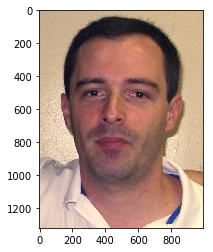

In [24]:
img_url = 'https://github.com/MarcoBauer72/AI/blob/master/Marco1.jpg?raw=true'

# Get the image and show it
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
imshow(img)
jsonData = get_image_features(img_url)
desc = jsonData['description']['captions'][0]['text']
print(desc)

## Using the Face API


### Create a Face API Service
https://portal.azure.com.


In [33]:
faceURI = "https://facerecobauer13.cognitiveservices.azure.com/face/v1.0/"
faceKey = "2d15b3cd8f9647aeb1e04b44134163ed"

Install the Face SDK package. This makes it easier to work with.


In [26]:
!pip install cognitive_face
!pip install pillow

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


Detect a face in an image:

Face 1:c992e5a9-a929-45a0-ba36-8e9c3487a421


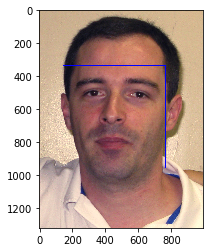

In [34]:
%matplotlib inline
import requests
from io import BytesIO
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw
import cognitive_face as CF

# Set URI and Key
CF.Key.set(faceKey)
CF.BaseUrl.set(faceURI)

# Detect faces in an image
img_url = 'https://github.com/MarcoBauer72/AI/blob/master/Marco1.jpg?raw=true'
result = CF.face.detect(img_url)

# Get the ID of the first face detected
face1 = result[0]['faceId']
print ("Face 1:" + face1)

# Get the image
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

# Add rectangles for each face found
color="blue"
if result is not None:
    draw = ImageDraw.Draw(img) 
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        left = faceRectangle['left']
        top = faceRectangle['top']
        width = faceRectangle['width']
        height = faceRectangle['height']
        draw.line([(left,top),(left+width,top)],fill=color, width=5)
        draw.line([(left+width,top),(left+width,top+height)],fill=color , width=5)
        draw.line([(left+width,top+height),(left, top+height)],fill=color , width=5)
        draw.line([(left,top+height),(left, top)],fill=color , width=5)

# show the image
imshow(img)


Compare with another image

Face 2:5d92c6ee-3862-4c42-b198-4c169ef51c1e
Not Verified
Confidence Level: 0.08268


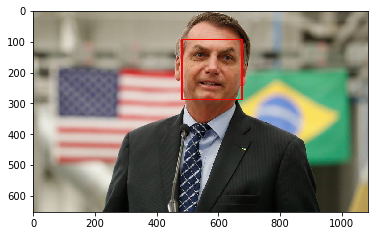

In [38]:
# Get the image to compare
img2_url = 'https://github.com/MarcoBauer72/AI/blob/master/BOZO.jpg?raw=true'
response2 = requests.get(img2_url)
img2 = Image.open(BytesIO(response2.content))

# Detect faces in a comparison image
result2 = CF.face.detect(img2_url)

# Assume the first face is the one we want to compare
face2 = result2[0]['faceId']
print ("Face 2:" + face2)

def verify_face(face1, face2):
    # By default, assume the match is unverified
    verified = "Not Verified"
    color="red"

    if result2 is not None:
        # compare the comparison face to the original one we retrieved previously
        verify = CF.face.verify(face1, face2)

        # if there's a match, set verified and change color to green
        if verify['isIdentical'] == True:
            verified = "Verified"
            color="lightgreen"

        # Display the second face with a red rectange if unverified, or green if verified
        draw = ImageDraw.Draw(img2) 
        for currFace in result2:
            faceRectangle = currFace['faceRectangle']
            left = faceRectangle['left']
            top = faceRectangle['top']
            width = faceRectangle['width']
            height = faceRectangle['height']
            draw.line([(left,top),(left+width,top)] , fill=color, width=5)
            draw.line([(left+width,top),(left+width,top+height)] , fill=color, width=5)
            draw.line([(left+width,top+height),(left, top+height)] , fill=color, width=5)
            draw.line([(left,top+height),(left, top)] , fill=color, width=5)

    # show the image
    imshow(img2)

    # Display verification status and confidence level
    print(verified)
    print ("Confidence Level: " + str(verify['confidence']))

verify_face(face1, face2)

And another?

Face 2:3eb7f251-2824-4509-b04f-6ad73adbea5f
Not Verified
Confidence Level: 0.0889


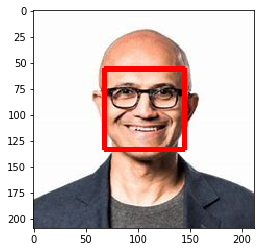

In [37]:
# Get the image to compare
img2_url = 'https://github.com/MarcoBauer72/AI/blob/master/Satya.jpg?raw=true'
response2 = requests.get(img2_url)
img2 = Image.open(BytesIO(response2.content))

# Detect faces in a comparison image
result2 = CF.face.detect(img2_url)

# Assume the first face is the one we want to compare
face2 = result2[0]['faceId']
print ("Face 2:" + face2)

verify_face(face1, face2)


And another?

Face 2:52416c86-5f9b-4aa9-b965-1259e230eae3
Not Verified
Confidence Level: 0.08666


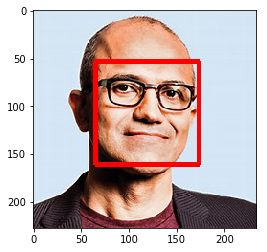

In [39]:
# Get the image to compare
img2_url = 'https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/satya.jpg'
response2 = requests.get(img2_url)
img2 = Image.open(BytesIO(response2.content))

# Detect faces in a comparison image
result2 = CF.face.detect(img2_url)

# Assume the first face is the one we want to compare
face2 = result2[0]['faceId']
print ("Face 2:" + face2)

verify_face(face1, face2)


No match!